In [1]:
# If deepinv cannot be found, change this to add your deepinv path
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [35]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, generate_signal, spectral_methods, cosine_similarity

In [36]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 1 with 32491 MiB free memory 


device(type='cuda', index=1)

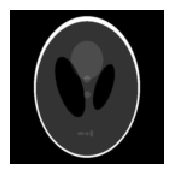

In [37]:
# Generate signal
x = generate_signal(
        shape = (1, 128, 128),
        mode = ['unit','shepp-logan'],
        phase_range=(-torch.pi/2, torch.pi/2),
        dtype=torch.complex64,
        device=device,
    )

plot(x.angle())

In [115]:
osr = 1.3
out_edge = int(np.sqrt(osr*128**2))
# Create model and generate measurements
physics = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, 128, 128),
    output_shape=(1, out_edge, out_edge),
    n_layers=2,
    transforms=['fourier2', 'fourier2'],
    diagonals=[['unit','uniform'],['marchenko','uniform']],
    device=device,
)

y = physics(x)

y.shape

torch.Size([1, 1, 145, 145])

In [118]:
# Cosine similarity before normalization
x_est = spectral_methods(y, physics, n_iter=5000)
print(x_est.abs())
cosine_similarity(x, x_est).item()

tensor([[[[1.7837, 0.0930, 0.4857,  ..., 2.0909, 1.4246, 0.4751],
          [0.1761, 0.3468, 0.2590,  ..., 0.6784, 1.8121, 0.0990],
          [0.2360, 0.4700, 1.1646,  ..., 1.3252, 0.5615, 0.2329],
          ...,
          [0.8210, 0.4894, 0.2377,  ..., 0.2606, 0.2576, 1.4798],
          [0.3487, 0.2406, 0.7351,  ..., 1.3223, 0.6873, 0.1735],
          [0.6755, 0.1834, 0.8746,  ..., 0.6728, 1.1567, 0.4183]]]],
       device='cuda:1')


0.2866572439670563

In [117]:
# Cosine similarity after normalization
x_est = x_est / x_est.abs()
x_est.abs()
cosine_similarity(x, x_est).item()

0.2408672273159027

In [119]:
def compute_lipschitz_constant(x_est, y, physics, mode='intensity'):
    # compute maximum eigenvalue of marchenko
    lambda_max = (1+np.sqrt(physics.oversampling_ratio))**2
    if mode == 'intensity':
        diag_max = (2*physics(x_est)-y).abs().max()
    elif mode == 'amplitude':
        diag_max = (1 - 0.5 * torch.sqrt(y) / torch.sqrt(physics(x_est))).abs().max()
    return 2 * lambda_max * diag_max

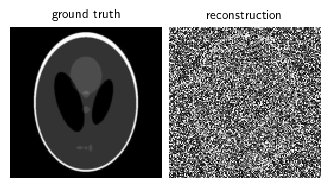

reconstruction accuracy: 0.2867


In [120]:
# Compare ground truth and reconstucted signal
x_est = correct_global_phase(x_est, x)
plot([x.angle(),x_est.angle()],['ground truth','reconstruction'])
print(f'reconstruction accuracy: {cosine_similarity(x, x_est).item():.4f}')

In [121]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=5000, **kwargs)
    z = spectral_methods(y, physics, n_iter=5000, **kwargs)
    return {"est": (x, z)}

In [122]:
# Algorithm parameters
data_fidelity = dinv.optim.data_fidelity.AmplitudeLoss()
prior = dinv.optim.prior.Zero()
L = compute_lipschitz_constant(x_est, y, physics, mode='amplitude')
print("lipschitz constant is", L.item())
params_algo = {"stepsize": 2/L.item(), "g_params": 0.00}
max_iter = 10000
early_stop = True
verbose = True

lipschitz constant is 3925.797119140625


/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zhhu/miniconda3/envs/deepinv2/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


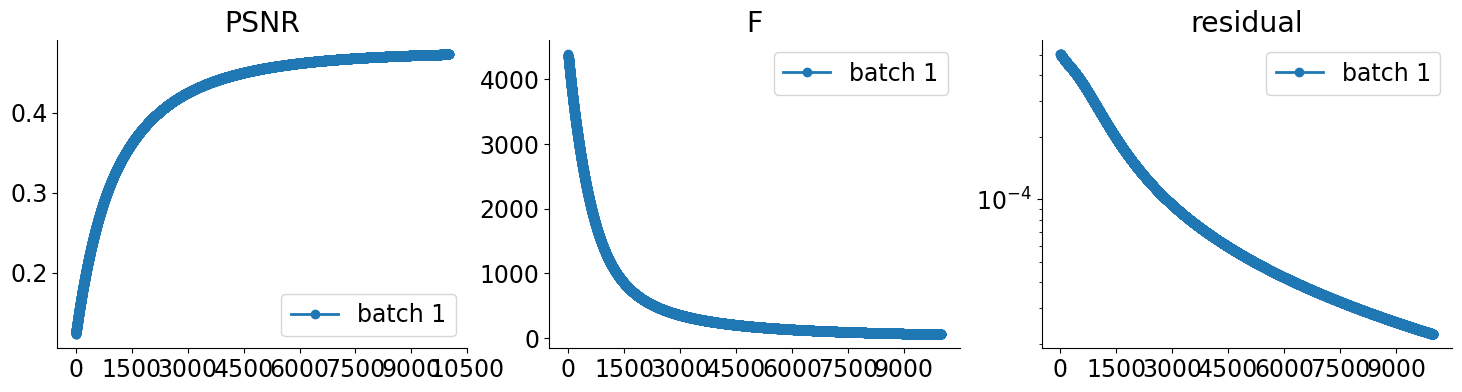

In [123]:
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.plotting import plot_curves


model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

# Run the algorithm
x_gd_est, metrics = model(y, physics, x_gt=x, compute_metrics=True)
plot_curves(metrics, show=True)

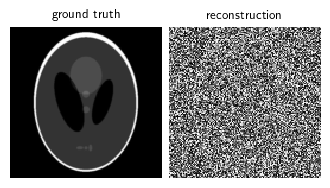

reconstruction accuracy: 0.1666


In [124]:
# Compare ground truth and reconstucted signal
x_gd_est = correct_global_phase(x_gd_est, x)
plot([x.angle(),x_gd_est.angle()],['ground truth','reconstruction'])
print(f'reconstruction accuracy: {cosine_similarity(x, x_gd_est).item():.4f}')